In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import torch
import torch_geometric
from torch_geometric.data import Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import networkx as nx

import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV

from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler



# **Load in Data Frames**

In [2]:
# categorical variable dataframe

file_path_trainC = "Data/Training Data/TRAINING_SOLUTIONS.xlsx"
df1 = pd.read_excel(file_path_trainC)


In [3]:
train_cat = pd.read_excel(file_path_trainC)
train_cat.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


In [4]:
train_cat.columns

Index(['participant_id', 'ADHD_Outcome', 'Sex_F'], dtype='object')

In [5]:
# Functional Connection Matrices

file_path_trainFCM = "Data/Training Data/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
df2 = pd.read_csv(file_path_trainFCM)

In [6]:
train_FCM = pd.read_csv(file_path_trainFCM)

In [7]:
train_FCM.head()

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.093473,0.146902,0.067893,0.015141,0.070221,0.063997,0.055382,-0.035335,0.068583,...,0.003404,-0.010359,-0.050968,-0.014365,0.128066,0.112646,-0.058980,0.028228,0.133582,0.143372
1,WHWymJu6zNZi,0.029580,0.179323,0.112933,0.038291,0.104899,0.064250,0.008488,0.077505,-0.004750,...,-0.008409,-0.008479,0.020891,0.017754,0.094040,0.035141,0.032537,0.075007,0.115350,0.138200
2,4PAQp1M6EyAo,-0.051580,0.139734,0.068295,0.046991,0.111085,0.026978,0.151377,0.021198,0.083721,...,0.053245,-0.028003,0.028773,0.024556,0.166343,0.058925,0.035485,0.063661,0.042862,0.162162
3,obEacy4Of68I,0.016273,0.204702,0.115980,0.043103,0.056431,0.057615,0.055773,0.075030,0.001033,...,-0.023918,-0.005356,0.018607,0.016193,0.072955,0.130135,0.056120,0.084784,0.114148,0.190584
4,s7WzzDcmDOhF,0.065771,0.098714,0.097604,0.112988,0.071139,0.085607,0.019392,-0.036403,-0.020375,...,0.066439,-0.076680,-0.047530,-0.031443,0.221213,0.007343,0.005763,0.083820,0.079582,0.067269


In [8]:
train_FCM.columns

Index(['participant_id', '0throw_1thcolumn', '0throw_2thcolumn',
       '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn',
       '0throw_6thcolumn', '0throw_7thcolumn', '0throw_8thcolumn',
       '0throw_9thcolumn',
       ...
       '195throw_196thcolumn', '195throw_197thcolumn', '195throw_198thcolumn',
       '195throw_199thcolumn', '196throw_197thcolumn', '196throw_198thcolumn',
       '196throw_199thcolumn', '197throw_198thcolumn', '197throw_199thcolumn',
       '198throw_199thcolumn'],
      dtype='object', length=19901)

In [9]:
print(train_FCM)

     participant_id  0throw_1thcolumn  0throw_2thcolumn  0throw_3thcolumn  \
0      70z8Q2xdTXM3          0.093473          0.146902          0.067893   
1      WHWymJu6zNZi          0.029580          0.179323          0.112933   
2      4PAQp1M6EyAo         -0.051580          0.139734          0.068295   
3      obEacy4Of68I          0.016273          0.204702          0.115980   
4      s7WzzDcmDOhF          0.065771          0.098714          0.097604   
...             ...               ...               ...               ...   
1208   kTurROKp5YHQ          0.022932          0.024830         -0.006514   
1209   FCRyMz9O6yCq          0.047078          0.135955          0.144366   
1210   vm2P1hmAY1hl          0.094541          0.145280          0.061964   
1211   OFxvN8lnw21w         -0.001533          0.128562          0.045000   
1212   9gpepMI9sj5q         -0.115224          0.147713          0.083183   

      0throw_4thcolumn  0throw_5thcolumn  0throw_6thcolumn  0throw_7thcolum

## Preprocess FCM to feed into GNN

In [10]:
train_FCM = train_FCM.drop(columns=['participant_id'])

def vector_to_adjacency(vector):
    #Converts a vector to an adjacency matrix

    adj_matrix = np.zeros((200, 200))

    # Fill the lower triangle of the matrix
    triu_indices = np.triu_indices(200, k=1)
    adj_matrix[triu_indices] = vector
    adj_matrix += adj_matrix.T  # Make it symmetric

    return adj_matrix

adj_matrices = np.array([vector_to_adjacency(row) for row in train_FCM.to_numpy()])
print(adj_matrices.shape)

(1213, 200, 200)


In [11]:
def adjacency_to_edge_list(adj_matrix, threshold=0.1):
    edge_index = np.array(np.where(adj_matrix > threshold))  # Only keep strong edges, helps with multicollinearity?
    edge_weight = adj_matrix[edge_index[0], edge_index[1]]

    return torch.tensor(edge_index, dtype=torch.long), torch.tensor(edge_weight, dtype=torch.float)

edge_data = [adjacency_to_edge_list(adj) for adj in adj_matrices]

#unpack weights and indices
edge_indices = [data[0] for data in edge_data]
edge_weights = [data[1] for data in edge_data]

print(edge_indices[0].shape) #shape will have two rows for source and target nodes
print(edge_weights[0].shape)

torch.Size([2, 862])
torch.Size([862])


In [12]:
#convert all edge lists to graph objects
graphs = [torch_geometric.data.Data(x=torch.eye(200), edge_index=e_idx, edge_attr=e_wt)
          for e_idx, e_wt in zip(edge_indices, edge_weights)]

print(graphs[0])

Data(x=[200, 200], edge_index=[2, 862], edge_attr=[862])


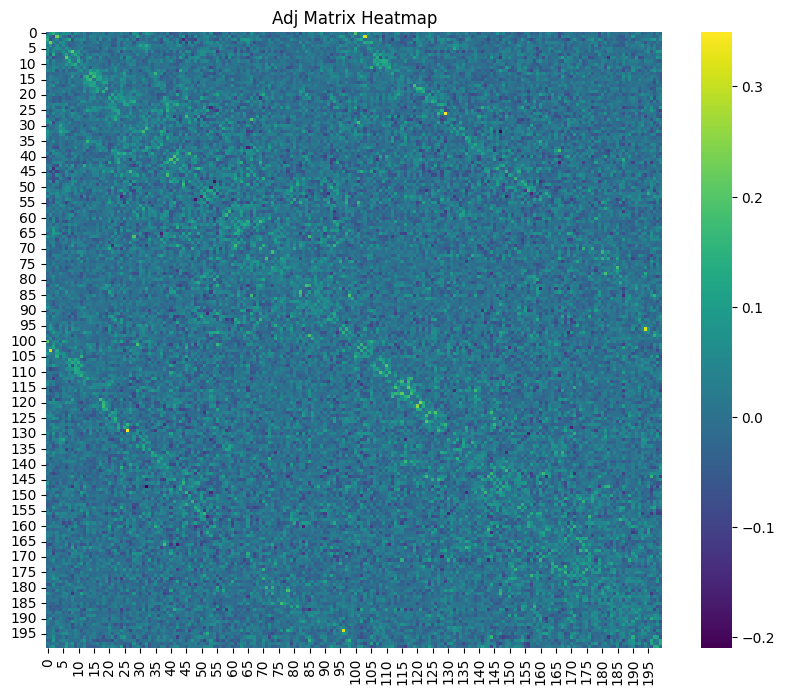

In [13]:
#validate conversions

sample_adj_matrix = adj_matrices[0]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sample_adj_matrix, cmap="viridis", square=True)
plt.title("Adj Matrix Heatmap")
plt.show()


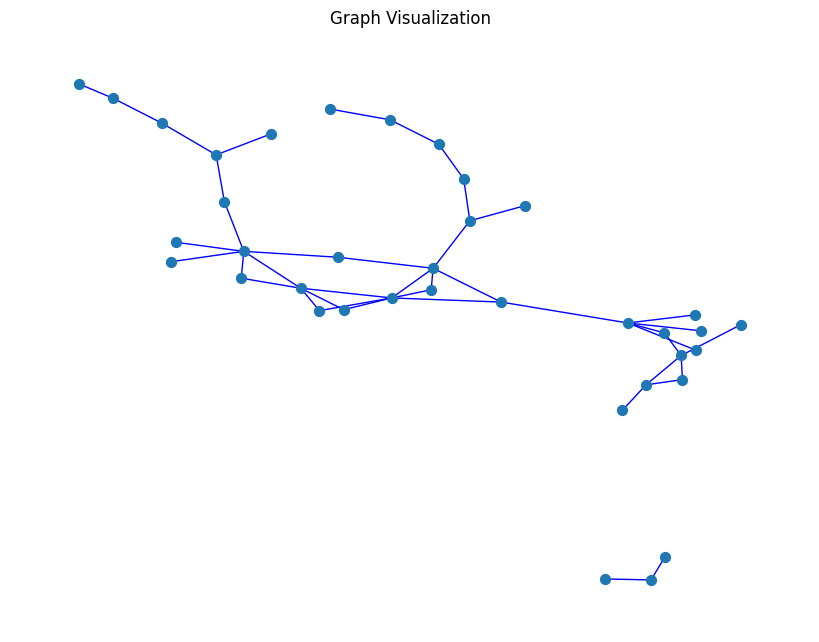

In [14]:
def visualize_graph(edge_index, title="Graph Visualization", node_limit=50):
    """
    Plots a NetworkX graph based on edge_index.
    """
    G = nx.Graph()
    edges = edge_index.numpy().T

    G.add_edges_from(edges[:node_limit])

    plt.figure(figsize=(8, 6))
    nx.draw(G, node_size=50, with_labels=False, edge_color="blue")
    plt.title(title)
    plt.show()

# graph first participant's graph
visualize_graph(edge_indices[0])

# **GCN Architecture**

In [15]:
#model architechture
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.2)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # First layer with ReLU
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        # Second layer
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        x = global_mean_pool(x, batch)  # Shape: [num_graphs, hidden_channels]
        
        # Final classification layer
        x = self.fc(x)
        return torch.nn.functional.log_softmax(x, dim=1)

In [16]:
label_df = pd.read_excel("Data/Training Data/TRAINING_SOLUTIONS.xlsx")
labels= torch.tensor(label_df.iloc[:, 1].values, dtype=torch.long)

# Split dataset (80% train, 10% val, 10% test)
train_idx, test_idx = train_test_split(range(len(labels)), test_size=0.2, random_state=42, stratify=labels)
train_idx, val_idx = train_test_split(train_idx, test_size=0.125, random_state=42, stratify=labels[train_idx])

train_mask = torch.zeros(len(labels), dtype=torch.bool)
val_mask = torch.zeros(len(labels), dtype=torch.bool)
test_mask = torch.zeros(len(labels), dtype=torch.bool)
model = GCN(in_channels=200, hidden_channels=64, out_channels=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

train_losses = []
val_losses = []
val_accuracies = []


model.train()
for epoch in range(200):
    optimizer.zero_grad()

    batch = Batch.from_data_list(graphs)
    out = model(batch)  # shape: [200, 10]

    loss = torch.nn.functional.nll_loss(out[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            val_loss = torch.nn.functional.nll_loss(out[val_mask], labels[val_mask])
            val_acc = (out[val_mask].argmax(dim=1) == labels[val_mask]).float().mean().item()
            val_losses.append(val_loss.item())  # Append val_loss
            val_accuracies.append(val_acc)      # Append val_acc
            print(f"Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val Acc: {val_acc:.4f}")

model.eval()
with torch.no_grad():
    test_loss = torch.nn.functional.nll_loss(out[test_mask], labels[test_mask])
    test_acc = (out[test_mask].argmax(dim=1) == labels[test_mask]).float().mean().item()

print(f"Test Loss: {test_loss.item()}, Test Accuracy: {test_acc:.4f}")

Epoch 0, Train Loss: 2.350355863571167, Val Loss: 2.3507955074310303, Val Acc: 0.0000
Epoch 20, Train Loss: 2.1501572132110596, Val Loss: 2.150378465652466, Val Acc: 0.3115
Epoch 40, Train Loss: 1.510650634765625, Val Loss: 1.5105361938476562, Val Acc: 0.6885
Epoch 60, Train Loss: 0.7430368065834045, Val Loss: 0.7413218021392822, Val Acc: 0.6885
Epoch 80, Train Loss: 0.636513888835907, Val Loss: 0.6334261894226074, Val Acc: 0.6885
Epoch 100, Train Loss: 0.6282951831817627, Val Loss: 0.625363290309906, Val Acc: 0.6885
Epoch 120, Train Loss: 0.6263369917869568, Val Loss: 0.6235718727111816, Val Acc: 0.6885
Epoch 140, Train Loss: 0.6254328489303589, Val Loss: 0.6226558089256287, Val Acc: 0.6885
Epoch 160, Train Loss: 0.6248593330383301, Val Loss: 0.6220662593841553, Val Acc: 0.6885
Epoch 180, Train Loss: 0.6244614720344543, Val Loss: 0.621666431427002, Val Acc: 0.6885
Test Loss: 0.6257869005203247, Test Accuracy: 0.6831


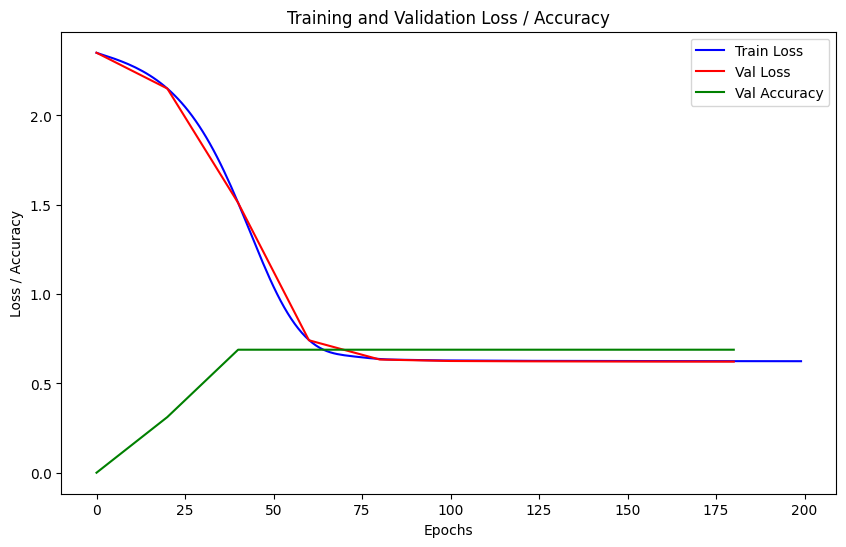

In [17]:
# Plotting the losses
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(range(200), train_losses, label="Train Loss", color="blue")

# Plot validation loss
plt.plot(range(0, 200, 20), val_losses, label="Val Loss", color="red")

# Plot validation accuracy
plt.plot(range(0, 200, 20), val_accuracies, label="Val Accuracy", color="green")

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Loss / Accuracy')
plt.legend()
plt.show()


In [18]:
# Quantitative variable train dataframe

file_path_trainQ = '/content/drive/My Drive/data csv/TRAIN_QUANTITATIVE.csv'
train_Quant = pd.read_csv(file_path_trainQ)
train_Quant.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/data csv/TRAIN_QUANTITATIVE.csv'

In [ ]:
train_Quant.columns

In [ ]:
# ADHD and Sex solutions dataframe for model training

file_path_trainS = '/content/drive/My Drive/data csv/TRAINING_SOLUTIONS.csv'
train_Solutions = pd.read_csv(file_path_trainS)
train_Solutions.head()

In [ ]:
train_Solutions.columns

# **Exploratory Data Analysis**

Use .info() and .describe() to summarize each dataset.

In [ ]:
train_cat.info()

Understand the distribution of the categorical variables with .value_counts().

In [ ]:
# Barratt_Barratt_P2_Occ - Barratt Simplified Measure of Social Status - Parent 2 Occupation
train_cat['Barratt_Barratt_P2_Occ'].value_counts()

# look back at the dictionary to see what category these integers [0, 45, 35] represent.

Notice the parent 2 occupation with the most frequency is 0: homemaker, stay at home parent.

**Visualize distributions:**

In [ ]:
sns.countplot(x='Barratt_Barratt_P2_Occ', data=train_cat[['Barratt_Barratt_P2_Occ']])
plt.title(f"Distribution of Barratt_Barratt_P2_Occ")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Distribution of MRI_Track_Age_at_Scan
train_Quant['MRI_Track_Age_at_Scan'].hist(figsize=(12, 10), bins=20)
plt.suptitle("MRI_Track_Age_at_Scan Distributions")
plt.xlabel('MRI_Track_Age_at_Scan')
plt.ylabel('Frequency Count')
plt.show()

In [ ]:
# Gender distribution
train_Solutions['Sex_F'].value_counts()

In [ ]:
train_Solutions['Sex_F'].value_counts().plot(kind='bar', color='blue')
plt.title('Gender Distribution')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.show()